# Model Validation Notebook

This notebook provides a comprehensive validation for all implemented time series generative models (parametric and non-parametric). It covers the entire pipeline from data preprocessing to model training and synthetic data generation, ensuring that each model functions as expected and produces output in the desired format `(R, l, N)`.

## Table of Contents:
1.  [Setup and Imports](#Setup-and-Imports)
2.  [Data Preprocessing](#Data-Preprocessing)
3.  [Parametric Model Validation](#Parametric-Model-Validation)
    *   [Geometric Brownian Motion](#Geometric-Brownian-Motion)
    *   [Ornstein-Uhlenbeck Process](#Ornstein-Uhlenbeck-Process)
    *   [Merton Jump Diffusion](#Merton-Jump-Diffusion)
    *   [Double Exponential Jump Diffusion](#Double-Exponential-Jump-Diffusion)
    *   [GARCH(1,1)](#GARCH-1-1)
    *   [Block Bootstrap](#Block-Bootstrap)
4.  [Non-Parametric Model Validation](#Non-Parametric-Model-Validation)
    *   [TimeGAN](#TimeGAN)
    *   [QuantGAN](#QuantGAN)



In [1]:
import sys
import numpy as np
import torch
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
project_root = Path().resolve().parents[0]
sys.path.append(str(project_root))

print(f"Project root added to sys.path: {project_root}")

from src.utils.preprocessing_utils import (
    create_dataloaders,
    preprocess_data
)

from src.utils.configs_utils import get_dataset_cfgs

from src.models.parametric.gbm import GeometricBrownianMotion
from src.models.parametric.ou_process import OUProcess
from src.models.parametric.merton_jump_diffusion import MertonJumpDiffusion
from src.models.parametric.garch11 import GARCH11
from src.models.parametric.de_jump_diffusion import DoubleExponentialJumpDiffusion

from src.models.non_parametric.block_bootstrap import BlockBootstrap
from src.models.non_parametric.time_vae import TimeVAE
from src.models.non_parametric.quant_gan import QuantGAN
from src.models.non_parametric.takahashi import TakahashiDiffusion

Project root added to sys.path: /Users/eddisonpham/Projects/Unified-benchmark-for-SDGFTS


/Users/eddisonpham/Projects/Unified-benchmark-for-SDGFTS/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing

This section demonstrates how to preprocess a sample dataset (`GOOG.csv`) using the provided utilities and create PyTorch `DataLoader` objects. This data will be used to train and validate our generative models.



In [2]:
nonparametric_cfg, parametric_cfg = get_dataset_cfgs()

In [3]:
# --- Normalized; Non-parametric case; Batched time series ---
print(f"Preprocessing normalized data with config: {nonparametric_cfg}")

train_data_np, valid_data_np, test_data_np, train_init_np, valid_init_np, test_init_np = preprocess_data(nonparametric_cfg)

batch_size = 32
train_loader_np, valid_loader_np, _ = create_dataloaders(
    train_data_np, 
    valid_data_np, 
    test_data_np,
    train_initial=train_init_np, 
    valid_initial=valid_init_np, 
    test_initial=test_init_np,
    batch_size=batch_size,
    train_seed=42,
    valid_seed=42,
    num_workers=0,
    pin_memory=False
)

print(f"\n[Normalized] Train data shape: {train_data_np.shape}")
print(f"[Normalized] Valid data shape: {valid_data_np.shape}")
print(f"[Normalized] Number of training batches: {len(train_loader_np)}")
print(f"[Normalized] Number of validation batches: {len(valid_loader_np)}")

num_samples_real, length = train_data_np.shape
print(f"\n[Normalized] Inferred model output dimensions: length={length}")


Preprocessing normalized data with config: {'index': 'spxusd', 'platform': 'MS', 'timeframe': 'M1', 'original_data_path': '/Users/eddisonpham/Projects/Unified-benchmark-for-SDGFTS/data/processed/combined_spxusd.csv', 'valid_ratio': 0.1, 'test_ratio': 0.1}
Preprocessing data for spxusd
Desired time series sample length (lag with max ACF >0): 52
ACF at that lag: -9.703853244659567e-05

[Normalized] Train data shape: torch.Size([233061, 52])
[Normalized] Valid data shape: torch.Size([29133, 52])
[Normalized] Number of training batches: 7284
[Normalized] Number of validation batches: 911

[Normalized] Inferred model output dimensions: length=52


In [4]:
# --- Unnormalized; Parametric Case; Use full time series ---
print(f"Preprocessing full dataset with configs: {parametric_cfg}")

train_data_para, valid_data_para, test_data_para, train_init_para, valid_init_para, test_init_para = preprocess_data(parametric_cfg)

print(f"\n[Unnormalized] Type of train_data_para: {type(train_data_para)}")
print(f"[Unnormalized] Type of valid_data_para: {type(valid_data_para)}")
print(f"[Unnormalized] Train data shape: {train_data_para.shape}")
print(f"[Unnormalized] Valid data shape: {valid_data_para.shape}")

length = train_data_para.shape
print(f"\n[Unnormalized] Inferred model output dimensions: length={length}")

Preprocessing full dataset with configs: {'index': 'spxusd', 'platform': 'MS', 'timeframe': 'M1', 'original_data_path': '/Users/eddisonpham/Projects/Unified-benchmark-for-SDGFTS/data/processed/combined_spxusd.csv', 'valid_ratio': 0.1, 'test_ratio': 0.1, 'is_parametric': True}
Preprocessing data for spxusd

[Unnormalized] Type of train_data_para: <class 'torch.Tensor'>
[Unnormalized] Type of valid_data_para: <class 'torch.Tensor'>
[Unnormalized] Train data shape: torch.Size([233102])
[Unnormalized] Valid data shape: torch.Size([29138])

[Unnormalized] Inferred model output dimensions: length=torch.Size([233102])


## Stochastic Model Validation

This section validates the functionality of each stochastic time series generative model. For each model, we will:
1.  Instantiate the model with appropriate parameters.
2.  Train the model using the preprocessed training data.
3.  Generate new synthetic time series samples.
4.  Verify the shape and basic statistics of the generated data.



In [5]:

def plot_generated_vs_real(generated_data, num_generated_samples, length, ground_truth):
    """
    Plots multiple generated univariate samples against the ground truth series.
    Each generated trajectory is plotted with a different color for differentiation.
    """
    import matplotlib.pyplot as plt

    y_real = ground_truth[:length]
    if hasattr(y_real, "detach"):
        y_real = y_real.detach().cpu().numpy()

    plt.figure(figsize=(12, 5))
    plt.plot(range(length), y_real, label="Ground Truth", color="blue", linewidth=2)
    
    # Pick colormap and assign colors
    n_samples = min(num_generated_samples, generated_data.shape[0])
    cmap = plt.get_cmap('tab10' if n_samples <= 10 else 'tab20')
    for i in range(n_samples):
        y_fake = generated_data[i, :]
        color = cmap(i % cmap.N)
        plt.plot(
            range(length),
            y_fake,
            color=color,
            alpha=0.8,
            label=f"Generated {i+1}" if n_samples > 1 else "Generated"
        )
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Geometric Brownian Motion




Validating Geometric Brownian Motion (GBM)
GBM Model instantiated: <src.models.parametric.gbm.GeometricBrownianMotion object at 0x13078ae40>
Fitting GBM model on full historical series...
mu: 3.364732404802155e-07, sigma: 0.0002678044437910892
Generated GBM forecast data shape: torch.Size([2, 29138])


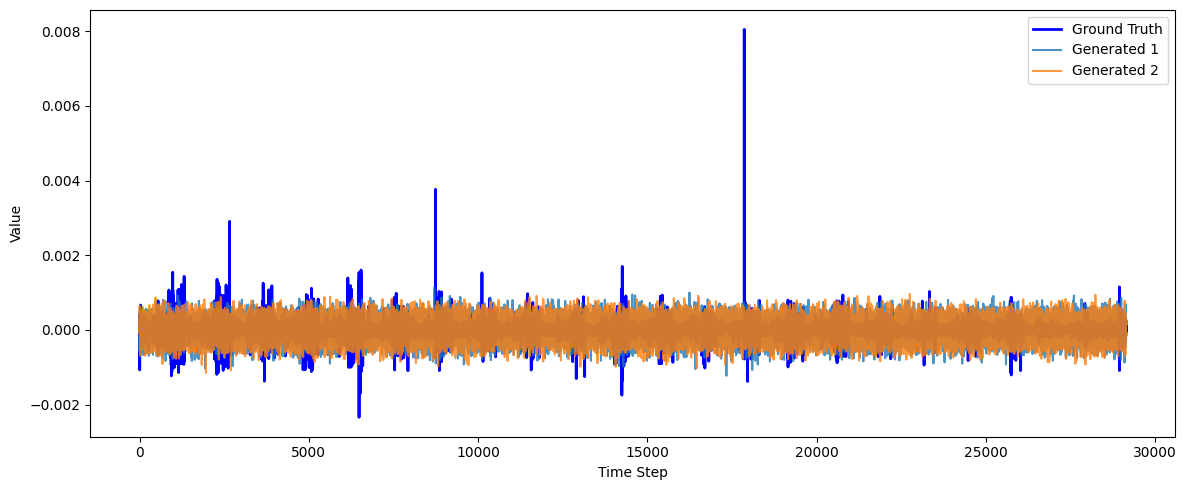

In [6]:
print("\n" + "=" * 50)
print("Validating Geometric Brownian Motion (GBM)")
print("=" * 50)

forecast_horizon = valid_data_para.shape[0]

gbm_model = GeometricBrownianMotion()
print(f"GBM Model instantiated: {gbm_model}")

print("Fitting GBM model on full historical series...")
gbm_model.fit(train_data_para)

num_generated_samples = 2
gbm_generated_data = gbm_model.generate(
    num_samples=num_generated_samples,
    generation_length=forecast_horizon
)
print(f"Generated GBM forecast data shape: {gbm_generated_data.shape}")
plot_generated_vs_real(gbm_generated_data, num_generated_samples, forecast_horizon, valid_data_para)

### Ornstein-Uhlenbeck Process




Validating Ornstein-Uhlenbeck Process (OU)
OU Model instantiated: <src.models.parametric.ou_process.OUProcess object at 0x1324fcc20>
Fitting OU model on full historical series...
mu: 3.391298258605317e-07, theta: 13.815510557964274, sigma: 0.0014077228903361934
Generated OU forecast data shape: torch.Size([2, 29138])


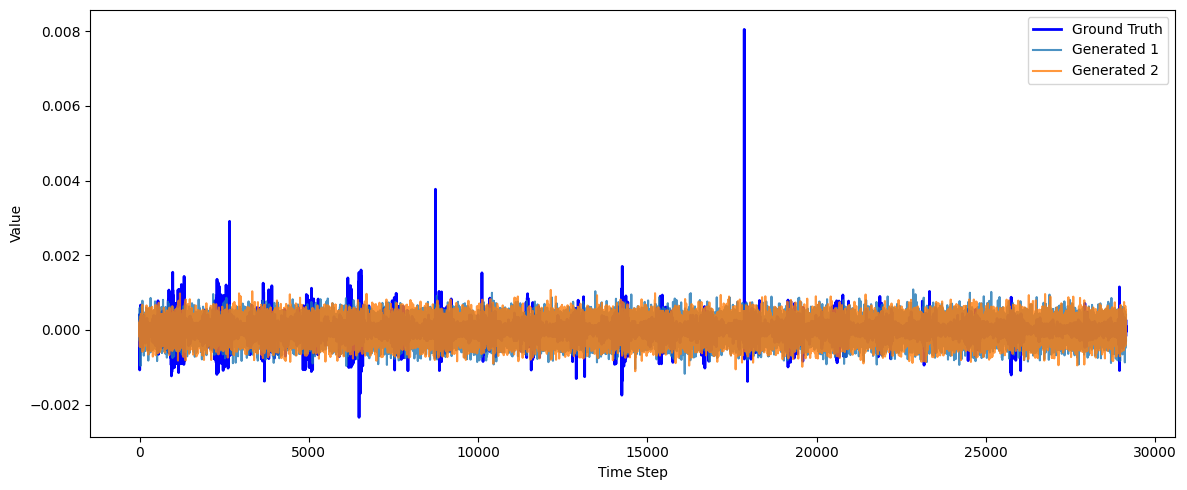

In [7]:
print("\n" + "=" * 50)
print("Validating Ornstein-Uhlenbeck Process (OU)")
print("=" * 50)

forecast_horizon = valid_data_para.shape[0]

ou_model = OUProcess()
print(f"OU Model instantiated: {ou_model}")

print("Fitting OU model on full historical series...")
ou_model.fit(train_data_para)

num_generated_samples = 2
ou_generated_data = ou_model.generate(
    num_samples=num_generated_samples,
    generation_length=forecast_horizon
)
print(f"Generated OU forecast data shape: {ou_generated_data.shape}")
plot_generated_vs_real(ou_generated_data, num_generated_samples, forecast_horizon, valid_data_para)

### Merton Jump Diffusion


Validating Merton Jump Diffusion (MJD)
MJD Model instantiated: <src.models.parametric.merton_jump_diffusion.MertonJumpDiffusion object at 0x1324fcad0>
Fitting MJD model on full historical series...
mu: 3.768223426097845e-07, sigma: 0.00026780386935429656, kappa: 3.168469393521889e-07, lam: 0.014169762593199544, mu_j: -9.419456774090948e-07, sigma_j: 0.001586689992748116
Generated MJD forecast data shape: torch.Size([2, 29138])


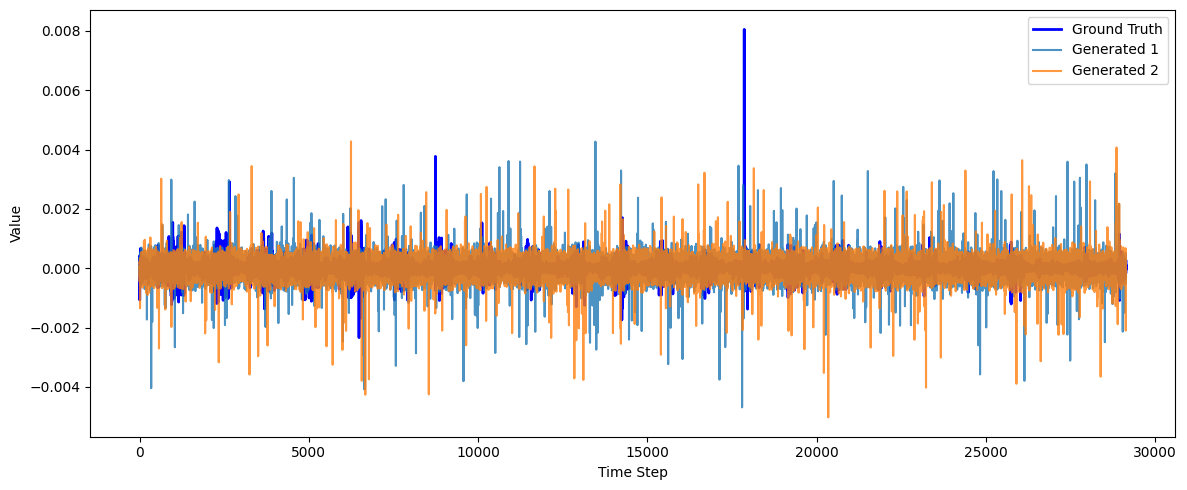

In [8]:
print("\n" + "=" * 50)
print("Validating Merton Jump Diffusion (MJD)")
print("=" * 50)

forecast_horizon = valid_data_para.shape[0]

mjd_model = MertonJumpDiffusion()
print(f"MJD Model instantiated: {mjd_model}")

print("Fitting MJD model on full historical series...")
mjd_model.fit(train_data_para)

num_generated_samples = 2
mjd_generated_data = mjd_model.generate(
    num_samples=num_generated_samples,
    generation_length=forecast_horizon
)
print(f"Generated MJD forecast data shape: {mjd_generated_data.shape}")
plot_generated_vs_real(mjd_generated_data, num_generated_samples, forecast_horizon, valid_data_para)

### GARCH(1, 1)


Validating GARCH(1,1)
GARCH(1,1) Model instantiated: <src.models.parametric.garch11.GARCH11 object at 0x1324fd2b0>
Fitting GARCH(1,1) model on full historical series...


/Users/eddisonpham/Projects/Unified-benchmark-for-SDGFTS/src/models/parametric/garch11.py:27: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  model_fit = am.fit(disp='off')


mu: 3.3647324048021977e-07, omega: 1.4343782488226637e-09, alpha: 0.1, beta: 0.88
Generated GARCH(1,1) forecast data shape: torch.Size([2, 29138])


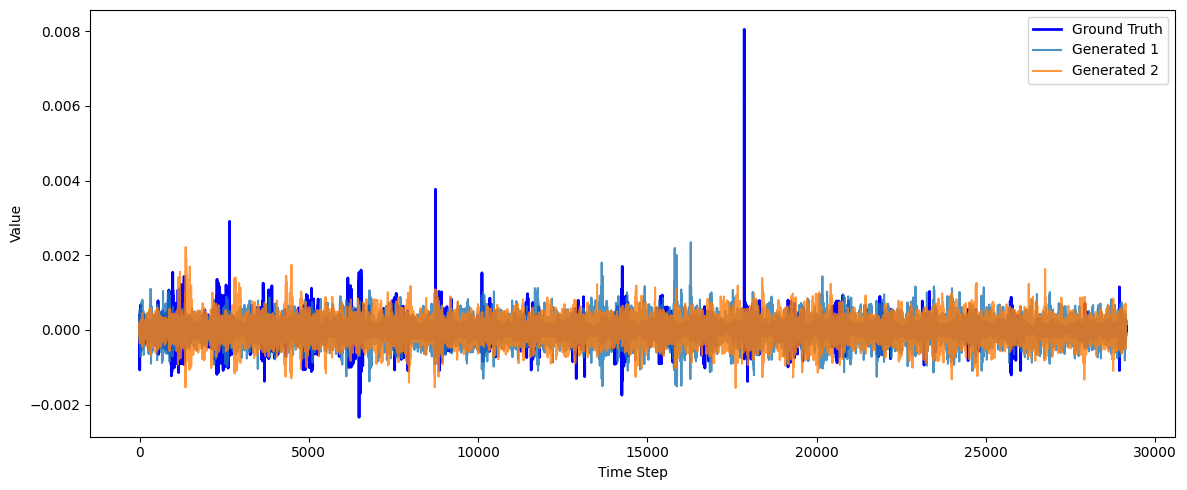

In [9]:
print("\n" + "=" * 50)
print("Validating GARCH(1,1)")
print("=" * 50)

forecast_horizon = valid_data_para.shape[0]

garch11_model = GARCH11()
print(f"GARCH(1,1) Model instantiated: {garch11_model}")

print("Fitting GARCH(1,1) model on full historical series...")
garch11_model.fit(train_data_para)

num_generated_samples = 2
garch11_generated_data = garch11_model.generate(
    num_samples=num_generated_samples,
    generation_length=forecast_horizon
)
print(f"Generated GARCH(1,1) forecast data shape: {garch11_generated_data.shape}")
plot_generated_vs_real(garch11_generated_data, num_generated_samples, forecast_horizon, valid_data_para)


### Double Exponential Jump Diffusion


Validating Double Exponential Jump Diffusion (DEJD)
DEJD Model instantiated: <src.models.parametric.de_jump_diffusion.DoubleExponentialJumpDiffusion object at 0x1324af770>
Fitting DEJD model on full historical series...
mu: 0.14990450494474458, sigma: 0.00011043034885204514, lam: 0.14990433372515036, p: 0.49921300403514296, eta1: 2003.3920933989673, eta2: 1998.537721220519, kappa: 0.9999988569304639
Generated DEJD forecast data shape: torch.Size([2, 29138])


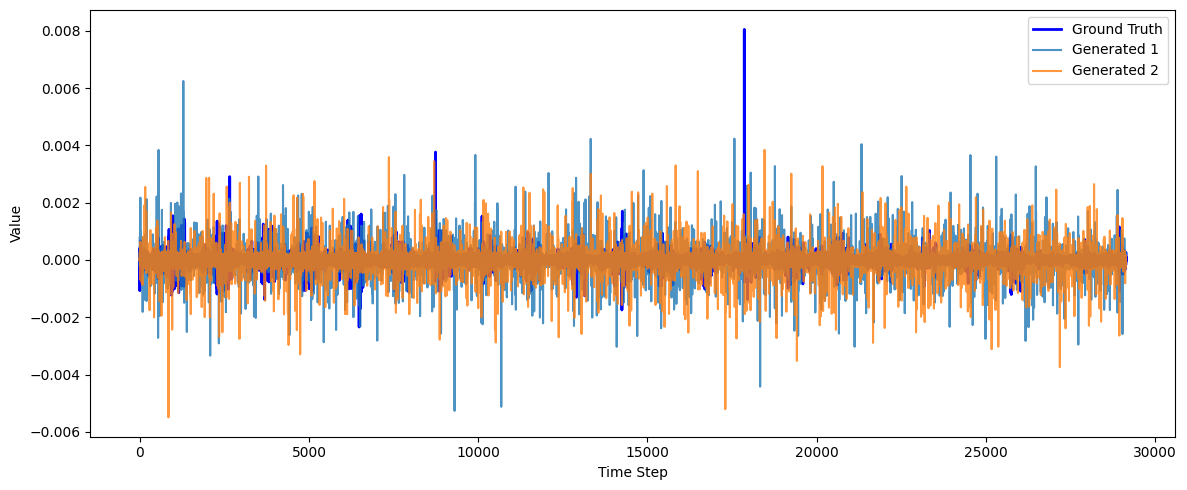

In [10]:
print("\n" + "=" * 50)
print("Validating Double Exponential Jump Diffusion (DEJD)")
print("=" * 50)

forecast_horizon = valid_data_para.shape[0]

dejd_model = DoubleExponentialJumpDiffusion()
print(f"DEJD Model instantiated: {dejd_model}")

print("Fitting DEJD model on full historical series...")
dejd_model.fit(train_data_para)

num_generated_samples = 2
dejd_generated_data = dejd_model.generate(
    num_samples=num_generated_samples,
    generation_length=forecast_horizon
)
print(f"Generated DEJD forecast data shape: {dejd_generated_data.shape}")
plot_generated_vs_real(dejd_generated_data, num_generated_samples, forecast_horizon, valid_data_para)

### Block Bootstrap


Validating Block Bootstrap Model
Block Bootstrap instantiated: <src.models.non_parametric.block_bootstrap.BlockBootstrap object at 0x1324afe00>
Fitting Block Bootstrap model on full historical series...
Generated Block Bootstrap forecast data shape: torch.Size([2, 29138])


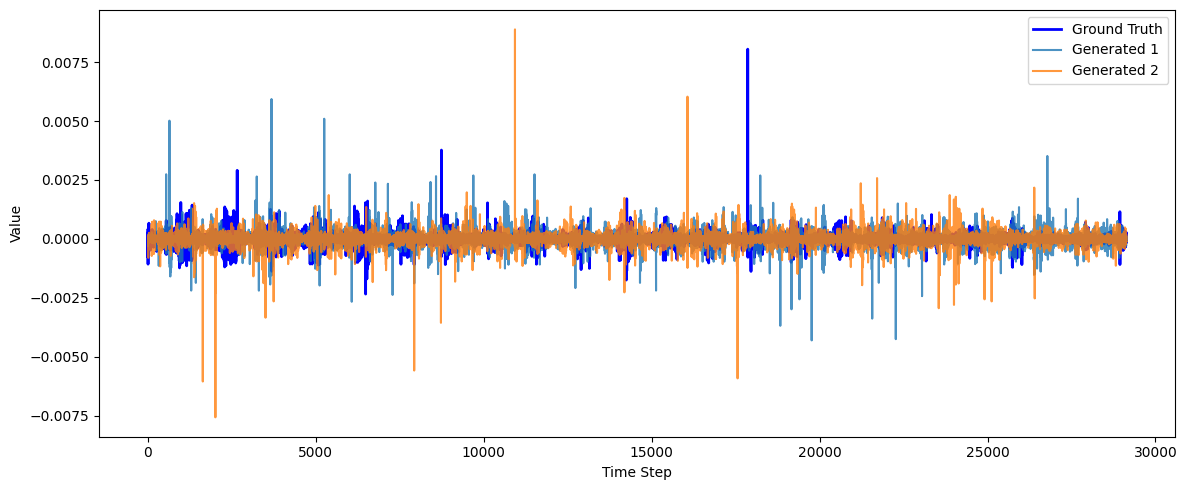

In [11]:
print("\n" + "=" * 50)
print("Validating Block Bootstrap Model")
print("=" * 50)

generation_length = valid_data_para.shape[0]

block_size = 103
num_realizations = 2

bootstrap_model = BlockBootstrap(block_size=block_size)
print(f"Block Bootstrap instantiated: {bootstrap_model}")

print("Fitting Block Bootstrap model on full historical series...")
bootstrap_model.fit(train_data_para)

generated_samples = bootstrap_model.generate(
    num_samples=num_realizations,
    generation_length=generation_length,
    seed=42
)
print(f"Generated Block Bootstrap forecast data shape: {generated_samples.shape}")

# Plot generated vs real
plot_generated_vs_real(generated_samples, num_realizations, generation_length, valid_data_para)



## Deep Learning Model Validation

This section validates the functionality of each deep learning time series generative model. For each model, we will:
1.  Instantiate the model with appropriate parameters.
2.  Train the model using the preprocessed training data.
3.  Generate new synthetic time series samples.
4.  Verify the shape and basic statistics of the generated data.

Note: GAN training can be unstable and convergence is not guaranteed with simple validation. This is primarily to check code execution and output format.



In [12]:
def plot_model_simulations_mean_dt(
    model,
    num_simulations=10, 
    sequence_length=100, 
    feature_idx=None
):
    """
    Generate and plot multiple deep learning model simulations on uniform linear time steps.
    Supports any model that implements a .generate(num_samples, seq_length=...) method and
    outputs tensors of shape (R, l).
    Assumes N=1 for channels and that channel dimension is not present in the output.
    """
    if hasattr(model, "eval"):
        model.eval()

    times = np.arange(sequence_length)
    with torch.no_grad():
        fake_series = model.generate(num_samples=num_simulations, generation_length=sequence_length)
    if isinstance(fake_series, torch.Tensor):
        fake_series = fake_series.cpu().numpy()
    sims = np.squeeze(fake_series)
    if sims.ndim == 1:
        sims = sims[None, :]
    if feature_idx is not None and feature_idx != 0:
        raise ValueError(f"feature_idx={feature_idx} out of bounds for single channel")

    plt.figure(figsize=(12, 6))
    for i in range(num_simulations):
        plt.plot(times, sims[i], label=f'Sim {i+1}', alpha=0.7)
    plt.title(f'{num_simulations} Model Simulations (Channel 0)')
    plt.xlabel("Time Index")
    plt.ylabel("Feature Value (Normalized)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### TimeVAE


In [13]:
print("\n" + "=" * 50)
print("Training TimeVAE")
print("=" * 50)

time_vae = TimeVAE(
    seq_len=52,
    input_dim=1,
    latent_dim=10,
    hidden_dim=30,
    lr=1e-5,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
print(f"TimeVAE model initialized")

print("Training TimeVAE model...")
time_vae.fit(train_loader_np, num_epochs=5)
print("TimeVAE training complete.")



Training TimeVAE
TimeVAE model initialized
Training TimeVAE model...
Epoch 001: Training loss 0.010296, recon 0.0051481, KL 2.1678
Epoch 002: Training loss 0.0034866, recon 1.493e-05, KL 0.34568
Epoch 003: Training loss 2.3701e-06, recon 1.1501e-06, KL 3.4932e-06
Epoch 004: Training loss 7.7808e-07, recon 3.8894e-07, KL 7.0966e-09
Epoch 005: Training loss 4.9638e-07, recon 2.4805e-07, KL 7.0492e-09
Best model restored with reconstruction loss 2.4805e-07
Training completed for 5 epochs.
TimeVAE training complete.


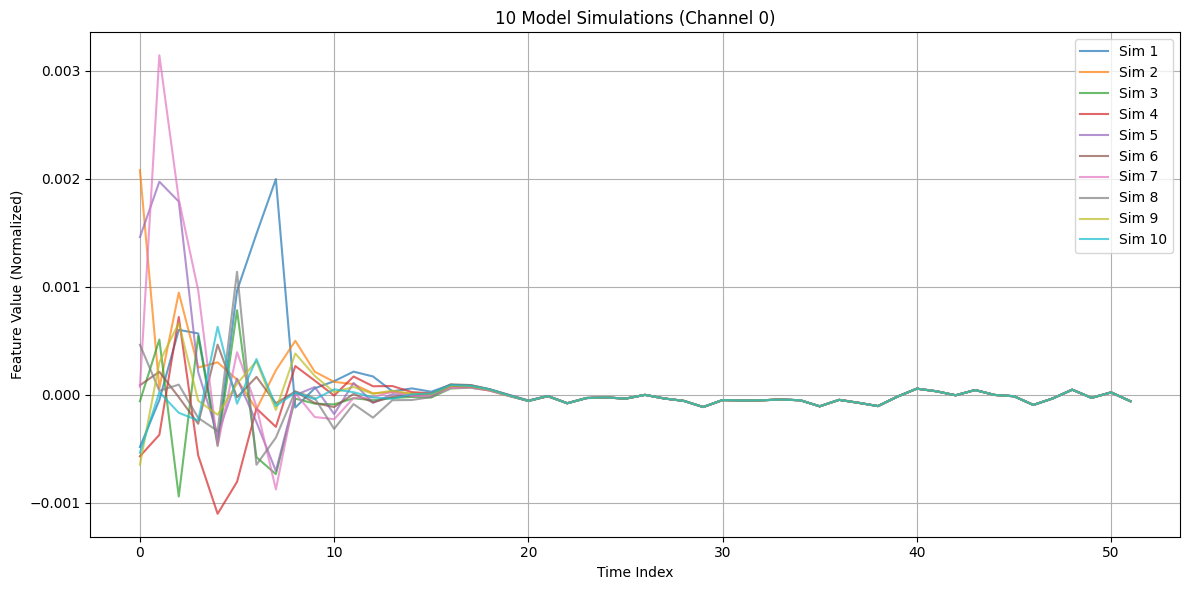

In [14]:
plot_model_simulations_mean_dt(model=time_vae, num_simulations=10, sequence_length=52)

### QuantGAN

In [ ]:

print("\n" + "=" * 50)
print("Training QuantGAN")
print("=" * 50)

quant_gan = QuantGAN(
    seq_len=52,
)

print("Training QuantGAN model...")
quant_gan.fit(train_loader_np, num_epochs=10)
print("QuantGAN training complete.")


Training QuantGAN
Training QuantGAN model...
Preprocessing data...
Training QuantGAN for 10 epochs...


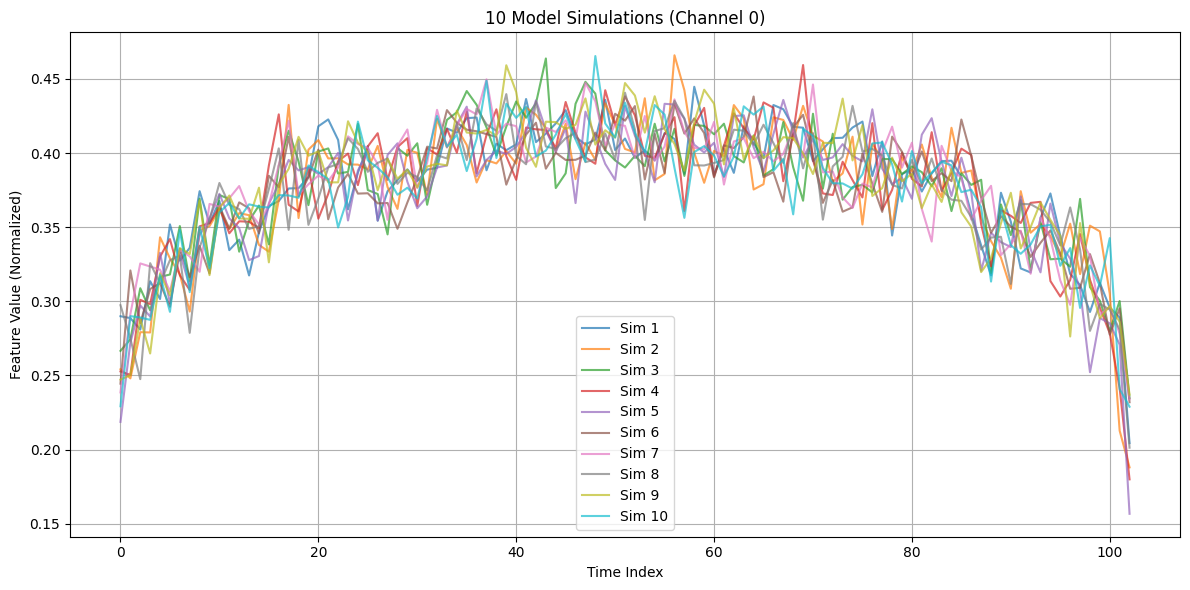

In [ ]:
plot_model_simulations_mean_dt(model=quant_gan, num_simulations=10, sequence_length=seq_length)

### Takahashi Diffusion

In [ ]:
print("\n" + "=" * 50)
print("Training Takahashi Diffusion Model")
print("=" * 50)

takahashi_model = TakahashiDiffusion(
    length=length,
)

print(f"Takahashi Diffusion model initialized on device: {takahashi_model.device}")

print("\nTraining Takahashi Diffusion model...")
takahashi_model.fit(train_loader_np, num_epochs=1)  # Reduced epochs for faster testing
print("Takahashi Diffusion training complete.")


Training Takahashi Diffusion Model
Takahashi Diffusion model initialized on device: cpu

Training Takahashi Diffusion model...
Inferred sequence length: 103
TakahashiDiffusion UNet trainable parameters: 15,722,625
Image dimensions: 8 x 128
TakahashiDiffusion epoch 1/1, Loss: 0.462188
Takahashi Diffusion training complete.


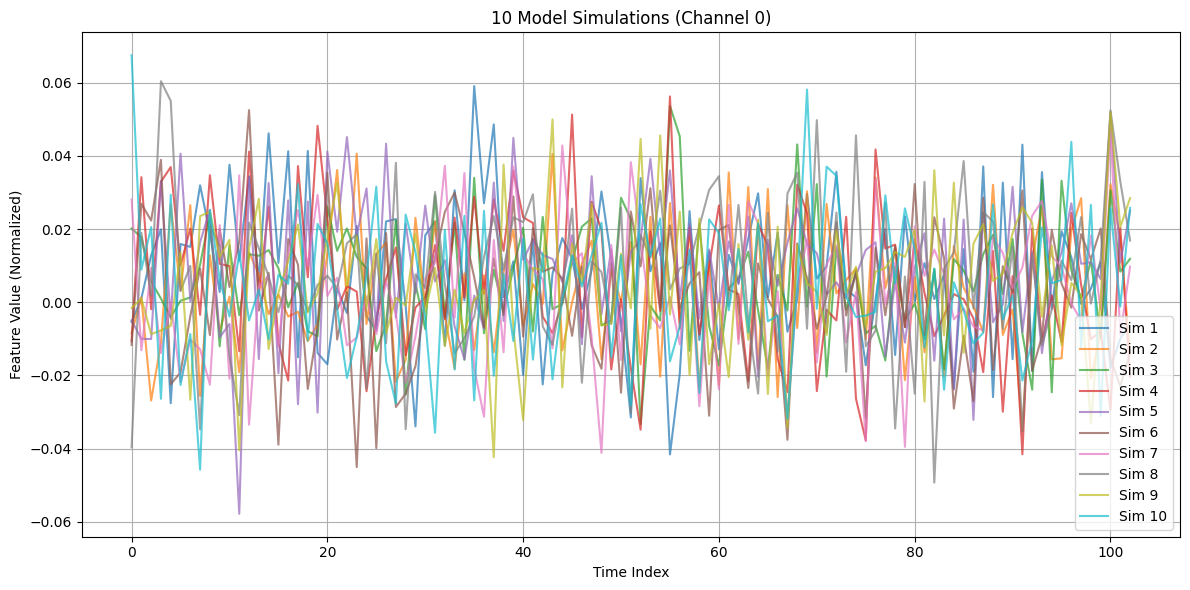

In [ ]:
plot_model_simulations_mean_dt(model=takahashi_model, num_simulations=10, sequence_length=seq_length)